In [1]:
# load dataset data/test.csv and data/train.csv

import pandas as pd

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(train.shape, test.shape)

train.head()

(120000, 2) (7600, 2)


,text,label
0,wall st bear claw back black reuters reuters s...,2
1,carlyle look toward commercial aerospace reute...,2
2,oil economy cloud stock outlook reuters reuter...,2
3,iraq halt oil export main southern pipeline re...,2
4,oil price soar alltime record posing new menac...,2


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create a TF-IDF vectorizer object for english
tfidf = TfidfVectorizer(stop_words='english')

# fit the object with the training data
tfidf.fit(train.text)

# transform the training data
train_tfidf = tfidf.transform(train.text)

# transform the test data
test_tfidf = tfidf.transform(test.text)

print(train_tfidf.shape, test_tfidf.shape)

(120000, 77346) (7600, 77346)


In [3]:
from sklearn.decomposition import LatentDirichletAllocation

# Number of topics
n_topics = 4

# Apply NMF for topic modeling on the vectorized data
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42).fit(train_tfidf)

# transform the training data
train_lda = lda.transform(train_tfidf) 

# transform the test data
test_lda = lda.transform(test_tfidf)

print(train_lda.shape, test_lda.shape)

(120000, 4) (7600, 4)


In [4]:
import numpy as np

# Get the dominant topic for each 
dominant_topics = np.argmax(train_lda, axis=1)

# distribution of dominant topics
import pandas as pd
pd.Series(dominant_topics).value_counts()

2    34772
1    33269
3    32295
0    19664
Name: count, dtype: int64

In [5]:
# print the top 15 words for each topic
feature_names = tfidf.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx}:")
    # print the top words with their probabilities
    for i in topic.argsort()[:-15 - 1:-1]:
        print(f"{feature_names[i]}: {topic[i]}")
    print()

Topic #0:
microsoft: 489.1737998751426
company: 395.5953682234731
search: 333.61394845240096
google: 332.10352643423994
new: 323.7171478863884
internet: 293.79175642856023
said: 280.61486075259813
court: 269.2780276018045
airline: 252.99089978778645
million: 243.95062513504587
drug: 241.4249447575216
window: 224.58367733149353
executive: 213.07462207383546
web: 193.8802714849606
software: 187.2528015429052

Topic #1:
iraq: 774.1429756099101
said: 654.6833345537598
ap: 617.5507594235959
president: 580.9232510682729
reuters: 507.5889578727835
minister: 484.57378694404633
bush: 478.10980651057383
killed: 453.24701141572683
election: 449.0156768566062
official: 446.1399969014698
iraqi: 412.3820589421937
people: 399.66943474817447
leader: 388.59664669985864
afp: 388.1438217031464
palestinian: 381.59158276195484

Topic #2:
oil: 907.0286870422356
price: 796.6798173029468
new: 752.8394453540242
reuters: 652.4047567464481
stock: 614.7545374148874
company: 595.1154714145796
profit: 533.197810569

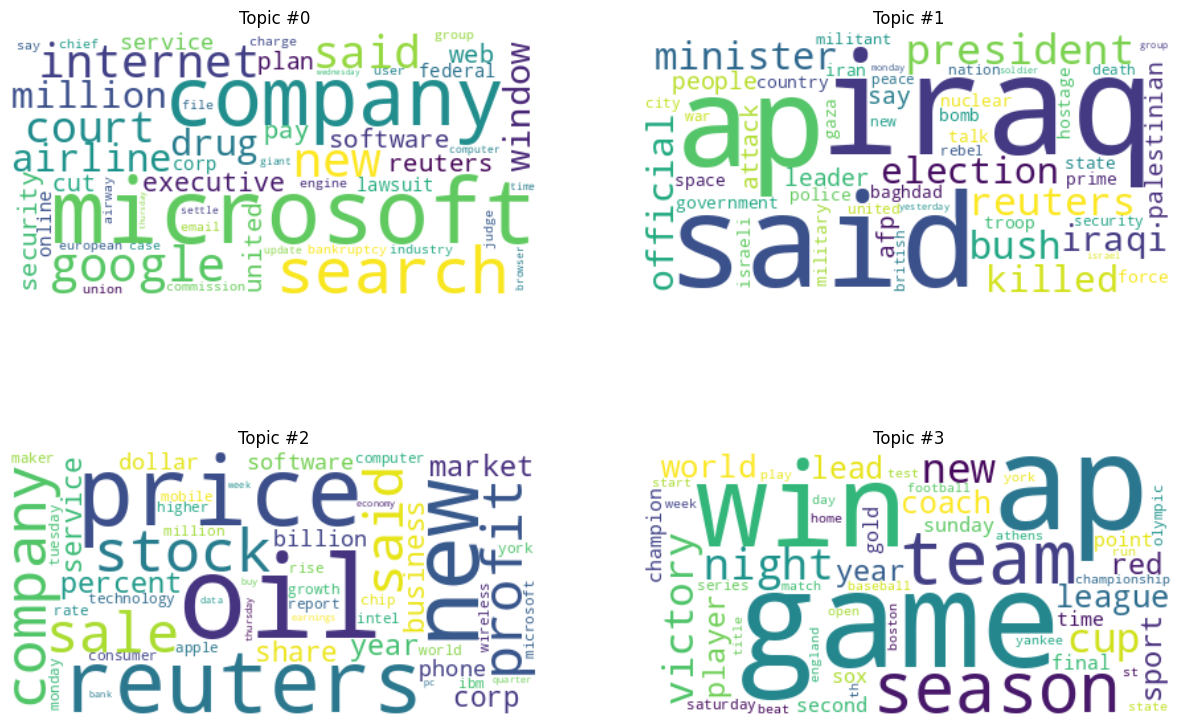

In [6]:
# use wordclouds to visualize each topic
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# Creating a word cloud for each topic
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

# no need to visualize the top 15, just visualize ALL the words
for topic_idx, topic in enumerate(lda.components_):
    # create a dataframe with words and their probabilities
    df = pd.DataFrame([feature_names, topic]).T
    df.columns = ['words', 'probabilities']
    # create a dictionary with words and their probabilities
    words = dict(zip(df.words, df.probabilities))
    # create the wordcloud
    wc = WordCloud(background_color='white', max_words=50)
    wc.generate_from_frequencies(words)
    # plot the wordcloud
    axs[topic_idx].imshow(wc, interpolation='bilinear')
    axs[topic_idx].set_title(f'Topic #{topic_idx}')
    axs[topic_idx].axis('off')
    
plt.show()

In [7]:
import pandas as pd

n_labels = 4

# Initialize a DataFrame to store label counts per topic
label_counts_per_topic = pd.DataFrame(0, index=range(n_topics), columns=range(n_labels))

# Loop over the training data, train is a df with columns ['text', 'label']
for i in range(len(train)):
    topic = dominant_topics[i]
    label = train.label[i]
    label_counts_per_topic.loc[topic, label] += 1

label_percentages_per_topic = label_counts_per_topic.divide(label_counts_per_topic.sum(axis=1), axis=0)

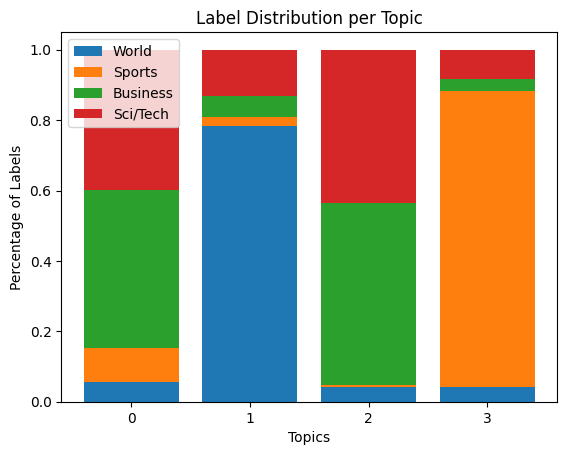

In [8]:
import matplotlib.pyplot as plt
import numpy as np

label_names = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

topic_label_count = np.zeros((n_topics, n_labels))

# Count the labels for each topic
for doc_idx, topic in enumerate(dominant_topics):
    label = train.label[doc_idx]
    topic_label_count[topic, label] += 1

# Convert counts to percentages
topic_label_percentage = topic_label_count / topic_label_count.sum(axis=1, keepdims=True)

# Plotting
fig, ax = plt.subplots()
for label in range(n_labels):
    # Compute bottom position for each bar
    bottom = np.sum(topic_label_percentage[:, :label], axis=1)
    ax.bar(range(n_topics), topic_label_percentage[:, label], bottom=bottom, label=label_names[label])

ax.set_xlabel('Topics')
ax.set_ylabel('Percentage of Labels')
ax.set_title('Label Distribution per Topic')
ax.set_xticks(range(n_topics))
ax.legend()
plt.show()

In [9]:
# let's do the same thing for the test data
# Get the dominant topic for each 
dominant_topics = np.argmax(test_lda, axis=1)

pd.Series(dominant_topics).value_counts()

2    2234
1    2114
3    2029
0    1223
Name: count, dtype: int64

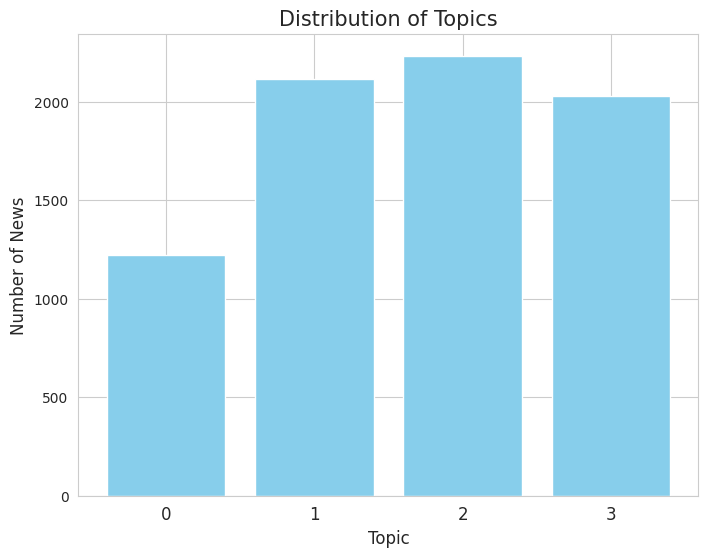

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Count the number of news items per topic
topic_counts = pd.Series(dominant_topics).value_counts().sort_index()

# Set a style (optional)
sns.set_style("whitegrid")

# Create a bar plot
plt.figure(figsize=(8, 6))  # Adjust size as needed
plt.bar(topic_counts.index, topic_counts.values, color='skyblue')

# Adding labels and title
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Number of News', fontsize=12)
plt.xticks(topic_counts.index, fontsize=12)
plt.title('Distribution of Topics', fontsize=15)

# Show plot
plt.show()

/tmp/ipykernel_3519853/848308501.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', n_labels)  # You can choose other colormaps like 'Set2', 'viridis', etc.


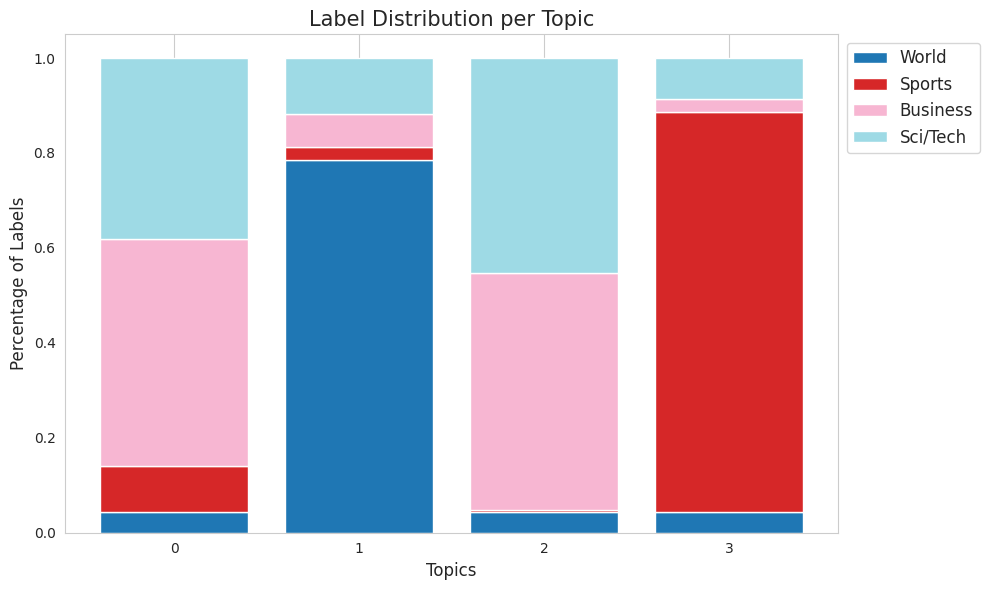

In [11]:
# Initialize a DataFrame to store label counts per topic
label_counts_per_topic = pd.DataFrame(0, index=range(n_topics), columns=range(n_labels))

# Loop over the training data, train is a df with columns ['text', 'label']
for i in range(len(test)):
    topic = dominant_topics[i]
    label = test.label[i]
    label_counts_per_topic.loc[topic, label] += 1

label_percentages_per_topic = label_counts_per_topic.divide(label_counts_per_topic.sum(axis=1), axis=0)

topic_label_count = np.zeros((n_topics, n_labels))

# Count the labels for each topic
for doc_idx, topic in enumerate(dominant_topics):
    label = test.label[doc_idx]
    topic_label_count[topic, label] += 1

# Convert counts to percentages
topic_label_percentage = topic_label_count / topic_label_count.sum(axis=1, keepdims=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed

# Select a color palette
colors = plt.cm.get_cmap('tab20', n_labels)  # You can choose other colormaps like 'Set2', 'viridis', etc.

for label in range(n_labels):
    # Compute bottom position for each bar
    bottom = np.sum(topic_label_percentage[:, :label], axis=1)
    ax.bar(range(n_topics), topic_label_percentage[:, label], bottom=bottom, color=colors(label), label=label_names[label])

ax.set_xlabel('Topics', fontsize=12)
ax.set_ylabel('Percentage of Labels', fontsize=12)
ax.set_title('Label Distribution per Topic', fontsize=15)
ax.set_xticks(range(n_topics))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
ax.grid(axis='y')  # Add horizontal gridlines

plt.tight_layout()  # Adjust layout to fit everything
plt.show()